# test file formats

In [3]:
import bz2
import lzma
import json
import zstandard as zstd

In [8]:
def open_compressed(file_path):
    """
    Open compressed files based on their extension.
    Supports .bz2, .xz, and .zst.
    """
    if file_path.endswith('.bz2'):
        return bz2.BZ2File(file_path, 'rb')
    elif file_path.endswith('.xz'):
        return lzma.open(file_path, 'rb')
    elif file_path.endswith('.zst'):
        # For .zst, return a stream reader
        f = open(file_path, 'rb')  # Open file in binary mode
        dctx = zstd.ZstdDecompressor()
        return dctx.stream_reader(f)
    else:
        raise ValueError('Unsupported file extension.')

def read_sentences(file_path, chunk_size=10000):
    """
    Read JSON entries from a compressed file, extract the 'body' field,
    and yield chunks of size `chunk_size`.
    """
    buffer = []  # To store 'body' fields in chunks
    byte_buffer = b""  # For handling partial lines in `.zst` files

    with open_compressed(file_path) as f:
        # Iterate over the file
        for chunk in iter(lambda: f.read(8192), b""):  # Read file in binary chunks
            byte_buffer += chunk

            # Process each line in the byte buffer
            while b"\n" in byte_buffer:
                line, byte_buffer = byte_buffer.split(b"\n", 1)

                # Parse JSON and process the 'body' field
                entry = json.loads(line.decode("utf-8"))

                if 'body' not in entry or entry['author'] == '[deleted]':
                    continue

                # Truncate long 'body' fields
                body = entry['body']
                if len(body) > 2000:
                    body = body[:2000]

                # Add to the chunk buffer
                buffer.append(body)
                if len(buffer) >= chunk_size:
                    yield buffer
                    buffer = []

        # Handle any remaining partial JSON line
        if byte_buffer:
            entry = json.loads(byte_buffer.decode("utf-8"))
            if 'body' in entry and entry['author'] != '[deleted]':
                body = entry['body']
                if len(body) > 2000:
                    body = body[:2000]
                buffer.append(body)

        # Yield any leftovers in the chunk buffer
        if buffer:
            yield buffer


In [10]:
for sentences in read_sentences('/sciclone/data10/twford/reddit/reddit/comments/RC_2018-08.xz', chunk_size=10):
    print(sentences)
    break

['That’s amazing! Can you send me a link please?', 'Yea as amazing as this looks there is no way the cost is worth it when there are so few major airline crashes yearly.', 'Cuentan cosas del último vagón de cada metro, si eres gay té puede interesar. Si no, no. ', 'Manafort is getting deep dicked by Bobby Three Sticks. ', 'Silence...I guess that is your answer.', 'So I’ve often wondered this...\n\nLike I know most politicians don’t know a lot of what’s going on. And like you said, need-to-know basis. So I’ve always wondered...who *does* know all the dirty secrets, confidential information, and hidden doors, so to speak? Like what person or group knows all the shit that goes on behind closed doors?\n\nI’m sure it’s some people no one’s ever heard of which would make sense. But it’s just fascinating that there’s a layer below the politics and general government where shit actually happens. ', 'I actually dig this ', 'Hey we all need that reminder sometimes. Future you in a love affair wi

In [4]:
with lzma.open('/sciclone/data10/twford/reddit/reddit/comments/RC_2017-12.xz', 
               mode='rb') as f:
    for line in f:
        entry = json.loads(line)
        print(entry)
        break

{'author': 'Rainbow_Renegade', 'author_flair_css_class': None, 'author_flair_text': None, 'body': 'Always inviting you to go out to eat. My spoiled rich Malaysian friend causally asks me to get $25 ramen. ', 'can_gild': True, 'controversiality': 0, 'created_utc': 1512086400, 'distinguished': None, 'edited': False, 'gilded': 0, 'id': 'dql1dzj', 'is_submitter': False, 'link_id': 't3_7gm42l', 'parent_id': 't3_7gm42l', 'permalink': '/r/AskReddit/comments/7gm42l/what_screams_my_parents_are_rich/dql1dzj/', 'retrieved_on': 1514212661, 'score': 1, 'stickied': False, 'subreddit': 'AskReddit', 'subreddit_id': 't5_2qh1i', 'subreddit_type': 'public'}


# test GMM

In [23]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import umap
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [24]:
embed_path = '/sciclone/geograd/stmorse/reddit/embeddings'

In [27]:
yr = 2007
mo = 3

# load embeddings
with open(os.path.join(embed_path, f'embeddings_{yr}-{mo:02}.npz'), 'rb') as f:
    embeddings = np.load(f)['embeddings']

print(embeddings.shape)

(79638, 384)


In [28]:
gmm = GaussianMixture(
    n_components=50,
    covariance_type='full',
)
gmm.fit(embeddings)

KeyboardInterrupt: 

# data check

In [3]:
import os
import pickle

In [9]:
with open('/sciclone/geograd/stmorse/dtm/logs/data_out.log', 'r') as f:
    lines = []
    for line in f:
        if line.strip().startswith("Complete:"):
            parts = line.split()
            lines.append(int(parts[1]))
len(lines)

96

In [10]:
sum(lines)

1183625992

# cluster trajectories

In [5]:
import os
import pickle
import time

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
import umap

from sklearn.cluster import AgglomerativeClustering, HDBSCAN, SpectralClustering
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
base_path = '/sciclone/geograd/stmorse/reddit/mbkm_50'

In [7]:
start_year = 2007
end_year = 2015
start_month = 1
end_month = 12

years = [str(y) for y in range(start_year, end_year+1)]
months = [f'{m:02}' for m in range(start_month, end_month+1)]
yrmo = [(yr, mo) for yr in years for mo in months]

In [8]:
C = []
Ck = 50  # TODO: doesn't need to be the same every month
for year, month in yrmo:
    with open(os.path.join(base_path, f'models/model_cc_{year}-{month}.npz'), 'rb') as f:
        cc = np.load(f)['cc']
        if Ck != cc.shape[0]: print(Ck, cc.shape[0])
        C.append(cc)
C = np.vstack(C)
print(C.shape)

T = []
for year, month in yrmo:
    with open(os.path.join(base_path, f'tfidf/tfidf_{year}-{month}.pkl'), 'rb') as f:
        tfidf = pickle.load(f)
    # TODO: hacky, maybe 'tfidf' shouldn't be a dict
    for j in range(len(tfidf['tfidf'].keys())):
        T.append(tfidf['tfidf'][j]['keywords'])
print(len(T))

(600, 384)
600


In [9]:
u_embedder = umap.UMAP(
    n_neighbors=15,
    n_components=10,
    metric='euclidean',
    init='spectral',
    min_dist=0.1,
    spread=1.0
)

Cu = u_embedder.fit_transform(C)
Cu.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(600, 10)

In [10]:
Cu2d = umap.UMAP(n_components=2).fit_transform(C)
Cu2d.shape

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(600, 2)

## graph

In [8]:
G = nx.Graph()

n = C.shape[0]

for t in range(len(yrmo)):
    for i in range(Ck):
        ix = t*50 + i
        G.add_node(f'u_{t}_{i}',
                   x=Cu2d[ix,0],
                   y=Cu2d[ix,1])

threshold = 0.8

pairwise_distances = squareform(pdist(Cu))
n = Cu.shape[0]
W = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        group_i = i // 50
        topic_i = i % 50
        group_j = j // 50
        topic_j = j % 50
        if abs(group_i - group_j) <= 3:
            W[i,j] = np.exp(-pairwise_distances[i,j]**2 / (2*0.5**2))
            if W[i,j] >= threshold:
                G.add_edge(f'u_{group_i}_{topic_i}', 
                           f'u_{group_j}_{topic_j}', 
                           weight=W[i,j])

connected_components = list(nx.connected_components(G))
len(connected_components)

1803

In [9]:
np.unique([len(comp) for comp in connected_components], return_counts=True)

(array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  30,  33,  34,
         37,  41,  42,  47,  51,  55,  57,  66,  77,  84,  86, 115]),
 array([1188,  241,  116,   82,   32,   23,   20,   22,   12,    6,    7,
           4,    7,    4,    4,    3,    1,    4,    1,    3,    1,    2,
           1,    1,    1,    1,    4,    1,    2,    1,    1,    1,    1,
           1,    1,    1,    1,    1]))

In [10]:
trim_components = [component for component in connected_components if len(component) >= 15]

43


/local/scr/stmorse/TMPDIR/ipykernel_128403/3214165533.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x_coords, y_coords, s=50, c=colors[k], edgecolors='k', zorder=2)


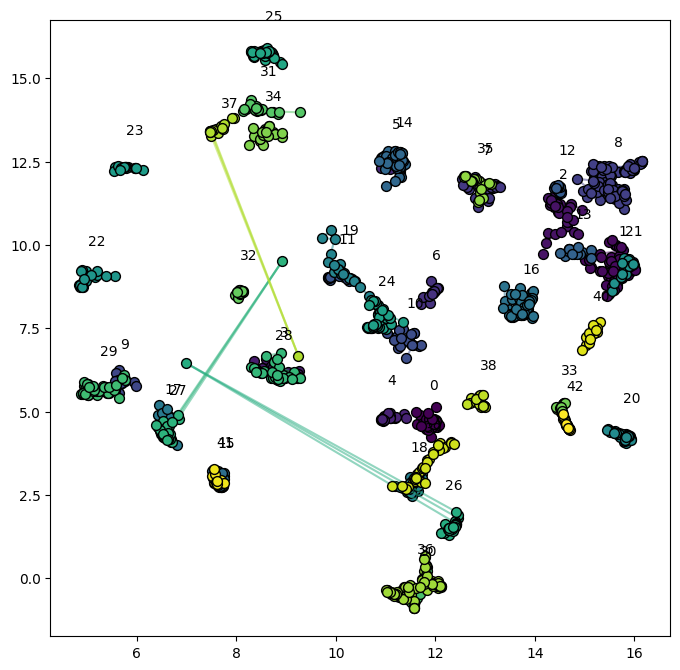

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

n_clusters = len(trim_components)
print(n_clusters)

colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k, component in enumerate(trim_components):
    if len(component) < 15:
        continue

    # Extract the subgraph
    subgraph = G.subgraph(component)

    # Get positions from node attributes
    pos = {node: (data['x'], data['y']) for node, data in subgraph.nodes(data=True)}

    # Plot edges
    for edge in subgraph.edges(data=True):
        x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
        y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
        ax.plot(x_coords, y_coords, color=colors[k], alpha=0.5)

    # Plot nodes
    x_coords = [pos[node][0] for node in subgraph.nodes()]
    y_coords = [pos[node][1] for node in subgraph.nodes()]
    ax.scatter(x_coords, y_coords, s=50, c=colors[k], edgecolors='k', zorder=2)

    xc = np.mean(np.array(x_coords))
    yc = np.mean(np.array(y_coords))
    ax.text(xc, yc + 1, k)
    
    # # Annotate nodes
    # for node, (x, y) in pos.items():
    #     plt.text(x, y, str(node), fontsize=12, ha='center', va='center', zorder=3)

    # # Annotate edge weights
    # for edge in subgraph.edges(data=True):
    #     x_mid = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
    #     y_mid = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
    #     plt.text(x_mid, y_mid, str(edge[2]['weight']), fontsize=10, ha='center', va='center', backgroundcolor='white')

plt.show()

In [22]:
coi = 26

for x in trim_components[coi]:
    u, t, i = x.split('_')
    t = int(t)
    i = int(i)
    idx = t*50 + i
    print(f'{t}-{i} ({idx // 50}): {T[idx][:5]}')

83-25 (83): ['ult' 'damage' 'enemy' 'mana' 'lane']
93-8 (93): ['sr' 'orb' 'water' 'metal' 'wood']
87-13 (87): ['team' 'enemy' 'mode' 'lane' 'played']
57-10 (57): ['nerf' 'team' 'game' 'zerg' 'units']
67-40 (67): ['pls' 'ult' 'lane' 'damage' 'karthus']
65-27 (65): ['damage' 'ult' 'dps' 'build' 'hp']
64-16 (64): ['build' 'dps' 'damage' 'ar' 'armor']
92-13 (92): ['she' 'her' 'lane' 'champion' 'ahri']
91-1 (91): ['damage' 'ult' 'mana' 'buff' 'aoe']
92-5 (92): ['damage' 'lightning' 'ww' '2x' 'build']
93-25 (93): ['damage' '1x' 'team' 'lane' 'runes']
66-24 (66): ['lane' 'ult' 'ap' 'ad' 'damage']
55-15 (55): ['team' 'ap' 'lane' 'boots' 'runes']
73-6 (73): ['lane' 'jungle' 'ap' 'fixed' 'team']
75-38 (75): ['players' 'pro' 'competitive' 'game' 'games']
87-7 (87): ['damage' 'ring' 'crit' 'build' 'd3']
94-10 (94): ['hp' 'survives' 'damage' 'team' 'wind']
85-43 (85): ['1x' 'sb' '2x' '1st' 'deck']
95-25 (95): ['wind' '31' 'water' 'fire' 'mana']
70-4 (70): ['lane' 'jungle' 'damage' 'ad' 'ult']
88-32

## spectral

In [11]:
pairwise_distances = squareform(pdist(Cu))
n = Cu.shape[0]
W = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        group_i = i // 50
        group_j = j // 50
        if abs(group_i - group_j) <= 3:
            W[i,j] = np.exp(-pairwise_distances[i,j]**2 / (2*0.5**2))
            # W[i,j] = pairwise_distances[i,j]

In [12]:
sc = SpectralClustering(
    n_clusters=100,
    affinity='precomputed',
)
sc.fit(W)

np.unique(sc.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int32),
 array([ 13,  80,   2,  11,  23,   3,   2,  73,   6,   9,  22, 110,   3,
          5,  39,   4,  12,  10,   7,  10,   8,   6,   6,   5,   8,  38,
         10,  18,  15,  75,  12,  33,  15,  17,  19,  15,  16,  44,   9,
         15,  22,   8,  29,  57,  52,  10,  58,  16,  17,  13,  15,  20,
         14,  11,  11,  14,   8,  17,  31,  31,  16,  37,  43,  13,  27,
         19,  11,  21,   7,  39,  38,  12,  18,  42,  21,  25,  40,  21,
          4,  47,  79,  25,  21,  16,  25,  22,  16,  30,  19,  54,  20,
         36,  19,  

/local/scr/stmorse/TMPDIR/ipykernel_334808/1542184438.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


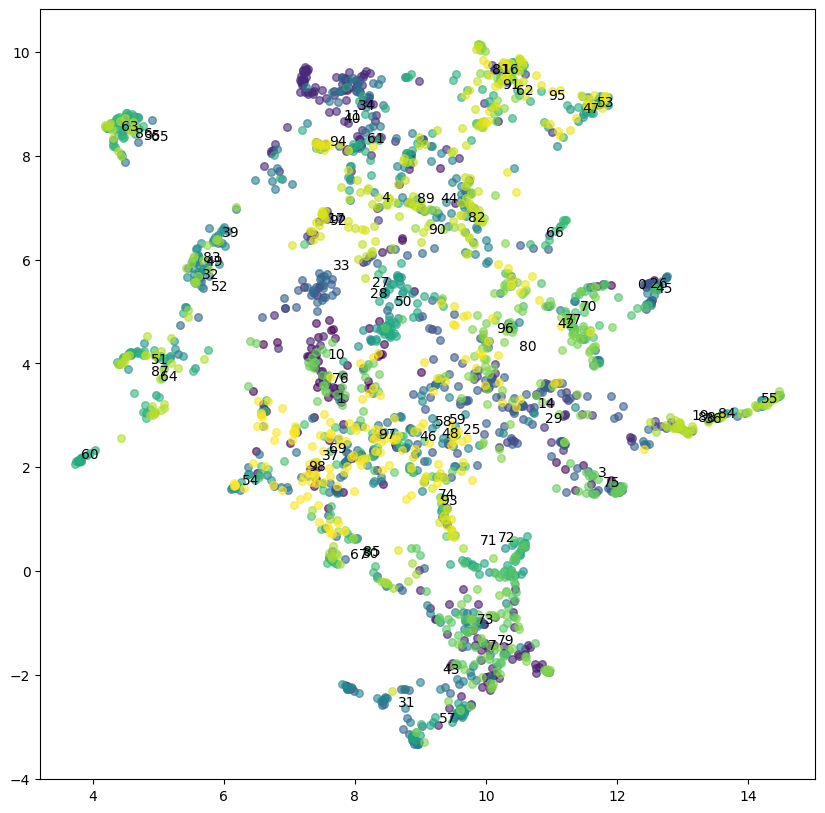

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(sc.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for k in range(n_clusters):
    idx = np.where(sc.labels_ == k)[0]
    if len(idx) < 10:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

plt.show()

## hdbscan

In [11]:
hdbs = HDBSCAN(
    min_cluster_size=3,
    min_samples=None,       # None defaults to min_cluster_size
    cluster_selection_epsilon=0.0,
    max_cluster_size=20,
    metric='euclidean',
    store_centers='both',   # centroid and medoid
)
hdbs.fit(Cu)

np.unique(hdbs.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75]),
 array([61, 10, 16, 11, 20, 16,  3,  7, 12, 14,  3, 13,  8,  8, 14,  3,  3,
        13,  4,  3,  5,  6,  5, 15,  5,  3, 12,  3, 10,  7,  6,  8,  8,  5,
        16,  8,  9, 13,  4,  4,  5,  5,  5, 12,  3,  3,  6,  4,  3,  4, 10,
         6,  4,  5,  8,  5,  4,  4,  4, 10, 11,  5,  4,  5,  5, 13, 10,  7,
         3,  4,  4,  6,  4,  3,  6,  3,  3]))

/local/scr/stmorse/TMPDIR/ipykernel_1823595/2126221267.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)


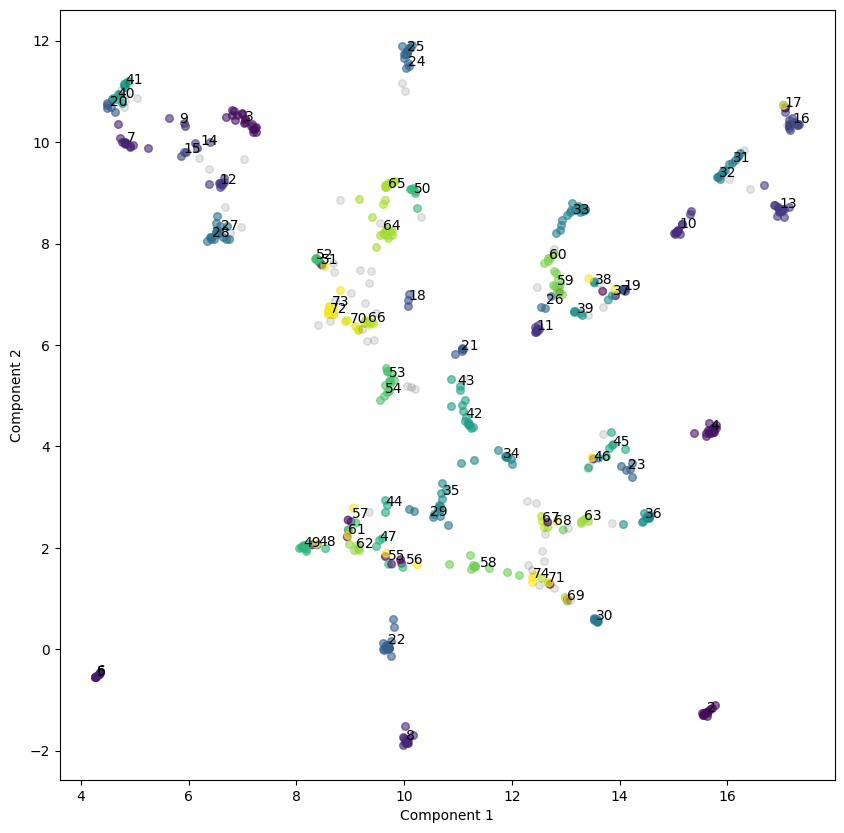

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

n_clusters = np.amax(hdbs.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# NOTE: skip outlier for viz
for k in range(2, n_clusters):
    idx = np.where(hdbs.labels_ == k)[0]

    if len(idx) < 2:
        continue
    
    ax.scatter(Cu2d[idx,0], Cu2d[idx,1], s=30, c=colors[k], alpha=0.6, label=k)

    centroid = np.average(Cu2d[idx,:], axis=0)
    ax.text(centroid[0], centroid[1], k)

# plot uncategorized
idx = np.where(hdbs.labels_ == -1)[0]
ax.scatter(Cu2d[idx, 0], Cu2d[idx, 1], s=30, c='k', alpha=0.1)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')

plt.show()

In [14]:
coi = 23

idx = np.where(hdbs.labels_ == coi)[0]
for x in idx:
    print(f'{x} ({x // 50}) ({hdbs.probabilities_[x]:.3f}): {T[x][:5]}')

170 (3) (1.000): ['animals' 'animal' 'pet' 'eat' 'eating']
359 (7) (1.000): ['dog' 'cat' 'pet' 'adorable' 'dogs']
372 (7) (1.000): ['animals' 'food' 'hunt' 'eat' 'animal']
450 (9) (0.308): ['animals' 'meat' 'food' 'animal' 'eat']
530 (10) (0.466): ['food' 'kids' 'eat' 'bag' 'room']


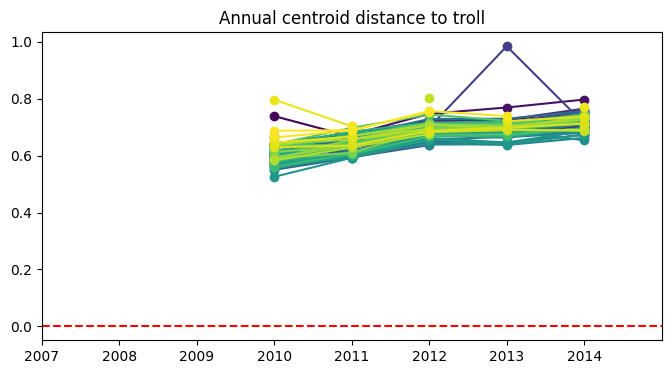

In [156]:
# check if cluster centroids are growing closer to each other
coi_a = 0
title = 'troll'

# coi_bs = [44, 58, 1, 15 ]
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
coi_bs = [i for i, c in zip(labs, cnts) if i != coi_a and i != -1 and c >= 15]
labels = ['politics (D)', 'politics (R)', 'religion', 'market']
colors = plt.cm.viridis(np.linspace(0, 1, len(coi_bs)))

idx_a = np.where(hdbs.labels_==coi_a)[0]

fig, ax = plt.subplots(1,1, figsize=(8,4))

for i, coi_b in enumerate(coi_bs):
    idx_b = np.where(hdbs.labels_==coi_b)[0]

    diffs = []
    for y in range(0, len(years)):
        split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]
        sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

        if len(sub_a) == 0 or len(sub_b) == 0:
            diffs.append(0)
            continue

        # compute average centroid
        avg_a = np.mean(C[sub_a], axis=0)
        avg_b = np.mean(C[sub_b], axis=0)

        # compute difference
        diff = np.linalg.norm(avg_a - avg_b)
        diffs.append(diff)

    diffs = np.array(diffs)

    diffs = np.where(diffs == 0, np.nan, diffs)
    ax.plot(range(len(diffs)), diffs, color=colors[i], linestyle='-', marker='o', label=coi_b)
    # ax.text(-0.5, diffs[0], labels[i])

ax.axhline(y=0, color='r', linestyle='--')
ax.set_xlim([0, len(years)])
ax.set_xticks(range(len(years)))
ax.set_xticklabels(range(start_year, end_year+1))
# ax.legend()
ax.set_title(f'Annual centroid distance to {title}')
plt.show()


In [161]:
labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 15]
n = len(labels_trim)

diffs = (-1) * np.ones((5, n, n))
for xy, y in enumerate(range(3, len(years))):
    split_0, split_1 = 12 * 50 * y, 12 * 50 * (y+1)

    for xa in range(n):
        coi_a = labels_trim[xa]
        idx_a = np.where(hdbs.labels_==coi_a)[0]
        sub_a = idx_a[np.where((idx_a >= split_0) & (idx_a < split_1))[0]]

        for xb in range(xa, n):
            coi_b = labels_trim[xb]
            idx_b = np.where(hdbs.labels_==coi_b)[0]
            sub_b = idx_b[np.where((idx_b >= split_0) & (idx_b < split_1))[0]]

            if len(sub_a) == 0 or len(sub_b) == 0:
                diffs[xy,xa,xb] = -1
                continue

            # compute average centroid
            avg_a = np.mean(C[sub_a], axis=0)
            avg_b = np.mean(C[sub_b], axis=0)

            # compute difference
            diff = np.linalg.norm(avg_a - avg_b)
            diffs[xy,xa,xb] = diff

diffs[diffs == -1] = np.nan

change = diffs[1:,:,:] - diffs[:-1,:,:]
print(change.shape)


(4, 70, 70)


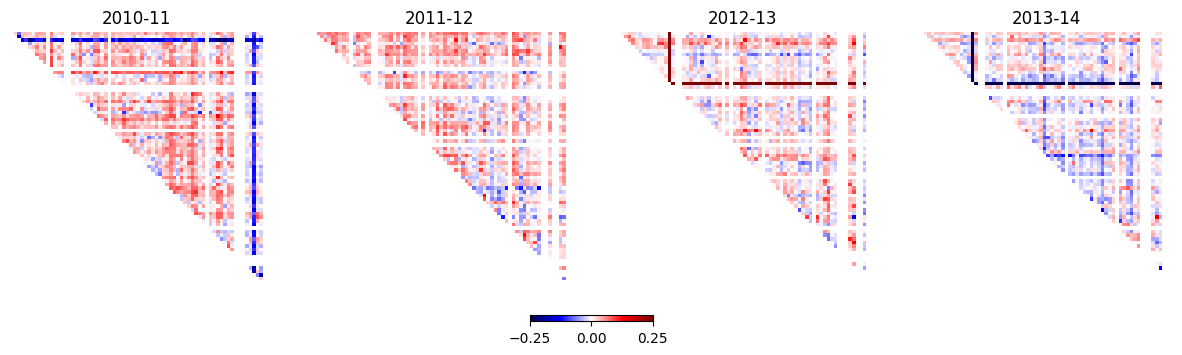

In [174]:
fig, ax = plt.subplots(1,4, figsize=(15,4), sharey=True)

titles = ['2010-11', '2011-12', '2012-13', '2013-14']
for i in range(4):
    cb = ax[i].imshow(change[i,:,:], 
                 cmap='seismic',
                 vmin=-0.25, vmax=0.25)
    
    ax[i].axis('off')
    ax[i].set_title(titles[i])

fig.colorbar(cb, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1)
# plt.tight_layout()
plt.show()

In [185]:
print(change[0,:5,:5])

[[ 0.          0.02335768 -0.07238881  0.02830082  0.03510942]
 [        nan  0.         -0.18090309  0.03442461  0.01825497]
 [        nan         nan  0.         -0.16067962 -0.09863035]
 [        nan         nan         nan  0.          0.00367121]
 [        nan         nan         nan         nan  0.        ]]


In [187]:
labels_trim[2]

np.int64(4)

## comparison to RW

/sciclone/geograd/stmorse/dtm/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


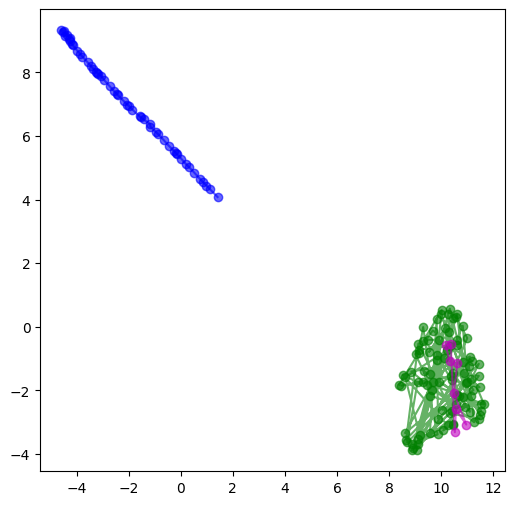

In [177]:
# vars
np.random.seed(314)
d = 384     # dimension
s = 1       # stdev
n = 50      # num steps (time periods)
cois = [3, 14]

# generate RW
steps = np.random.normal(loc=0, scale=s, size=(n, d))
walk = np.cumsum(steps, axis=0)

# get cluster centroids and standardize
clusters = []
lengths = []
for coi in cois:
    idx = np.where((hdbs.labels_==coi) & (hdbs.probabilities_>=0.75))[0]
    lengths.append(len(idx))

    # standardize
    Cm  = C[idx]
    Cm -= np.mean(Cm, axis=0)
    csd = np.std(Cm, axis=0)
    csd[csd == 0] = 1e-8   # gracefully handle any dims that are exact
    Cm /= csd

    clusters.append(Cm)
clusters = np.vstack(clusters)

# put in one matrix
data = np.vstack((
    walk, clusters
))

# dim reduce
data2d = umap.UMAP().fit_transform(data)

# plot
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(data2d[:n,0], data2d[:n,1], 
        color='b', linestyle='-', marker='o', alpha=0.6, label='RW')
ax.plot(data2d[n:(n+lengths[0]),0], data2d[n:(n+lengths[0]),1],
        color='g', linestyle='-', marker='o', alpha=0.6, label=f'Cluster {cois[0]}')
ax.plot(data2d[(n+lengths[0]):,0], data2d[(n+lengths[0]):,1],
        color='m', linestyle='-', marker='o', alpha=0.6, label=f'Cluster {cois[1]}')

# ax.legend()
plt.show()

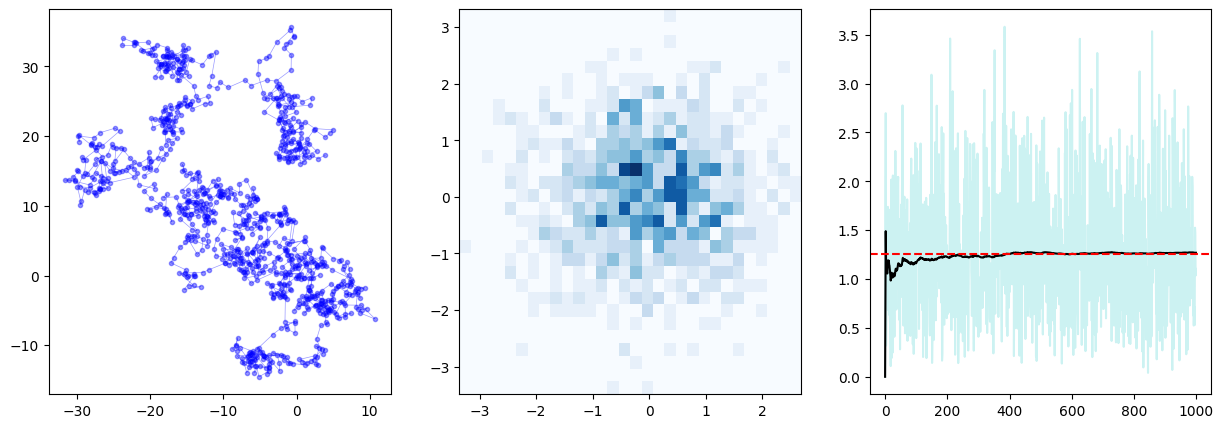

In [60]:
np.random.seed(11)

d = 2
s = 1
cov = s * np.identity(d)
n = 1000

steps = np.random.multivariate_normal([0,0], cov, size=n-1)
steps = np.vstack(([[0,0]], steps))
walk  = np.cumsum(steps, axis=0)

step_sizes = np.linalg.norm(steps, axis=1)

step_size_means = np.cumsum(step_sizes) / np.arange(1, n+1)

mean_steps = np.cumsum(steps, axis=0) / np.arange(1, n+1)[:, None]

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].plot(walk[:,0], walk[:,1], color='b', marker='.', linestyle='-', linewidth=0.5, alpha=0.4)
axs[1].hist2d(steps[:, 0], steps[:, 1], bins=30, cmap='Blues', density=True, cmin=0, cmax=1)

axs[2].plot(range(n), step_sizes, 'c-', alpha=0.2)
axs[2].plot(range(n), step_size_means, 'k-')
m = s * np.sqrt(np.pi / 2)
axs[2].axhline(y=m, color='r', linestyle='--')

plt.show()

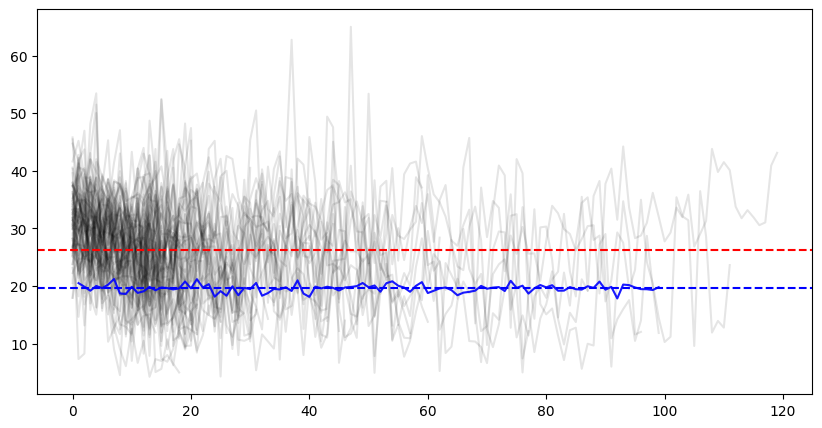

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

# PLOT CENTROID STEPS

labs, cnts = np.unique(hdbs.labels_, return_counts=True)
labels_trim = [i for i, c in zip(labs, cnts) if i != -1 and c >= 15]
n = len(labels_trim)

all_step_sizes = []

# look at mean step sizes and step mean in data
for coi in labels_trim:

    idx = np.where(hdbs.labels_==coi)[0]
    cstd = C[idx].copy()
    cstd -= np.mean(cstd, axis=0)
    std  = np.std(cstd, axis=0)
    std[std==0] = 1e-8
    cstd /= std
    steps = cstd[1:,:] - cstd[:-1,:]
    step_sizes = np.linalg.norm(steps, axis=1)
    all_step_sizes.append(step_sizes)

    ax.plot(range(len(step_sizes)), step_sizes, 'k-', alpha=0.1)

all_step_sizes = np.hstack(all_step_sizes)
total_mean_step_size = np.mean(all_step_sizes)

ax.axhline(y=total_mean_step_size, color='r', linestyle='--')

# PLOT RW

np.random.seed(314)
n = 100
d = 384
mu = np.zeros(d)
cov = 1 * np.identity(d)
steps = np.random.multivariate_normal(mu, cov, size=n-1)
steps = np.vstack((np.zeros((1,d)), steps))
walk  = np.cumsum(steps, axis=0)
step_sizes = np.linalg.norm(steps, axis=1)
ax.plot(range(1, len(step_sizes)), step_sizes[1:], 'b-', alpha=0.9)

# theoretical mean
p = 1 * np.sqrt(2) * np.sqrt(C.shape[1] / 2)
ax.axhline(y=p, color='b', linestyle='--')

plt.show()